# Previsão de Valor Mensal do Cliente (Regressão)

## Objetivo
Usar dados históricos de clientes Telco para prever o valor mensal esperado,
apoiando decisões de marketing, upsell e planejamento de receita.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
df = pd.read_csv("telco_churn.csv")
df.head()

,id_cliente,tempo_contrato_meses,valor_mensal,uso_dados_gb,qtd_reclamacoes,atraso_pagamento,recebeu_campanha,churn
0,1001,2,180,4,2,1,0,1
1,1002,36,95,28,0,0,1,0
2,1003,12,130,12,1,0,1,0
3,1004,1,200,3,3,1,0,1
4,1005,48,85,40,0,0,1,0


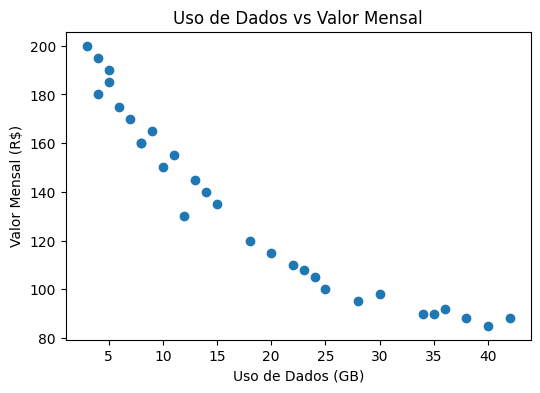

In [4]:
plt.figure(figsize=(6,4))
plt.scatter(df['uso_dados_gb'], df['valor_mensal'])
plt.xlabel("Uso de Dados (GB)")
plt.ylabel("Valor Mensal (R$)")
plt.title("Uso de Dados vs Valor Mensal")
plt.show()


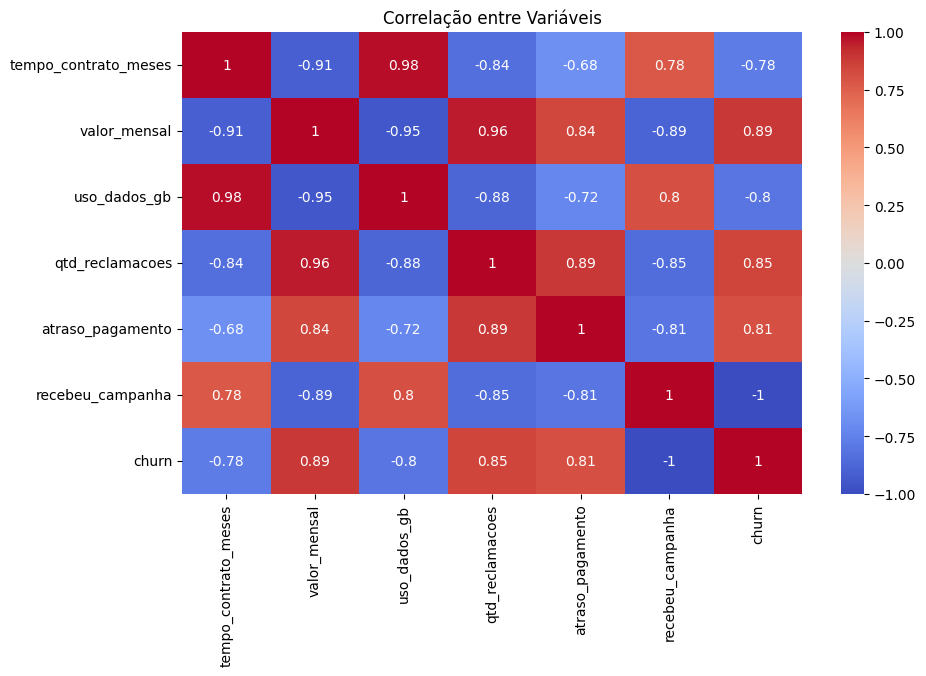

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(
    df.drop(columns=['id_cliente']).corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlação entre Variáveis")
plt.show()


## Correlação ≠ Relação causal isolada


uso_dados_gb tem correlação negativa forte (-0.95) com valor_mensal
Mas o modelo multivariado ficou bom (MAE ≈ 5.9)

O uso de dados sozinho engana.

## Limpeza e preparação do dado

In [6]:
X = df.drop(columns=['id_cliente', 'valor_mensal'])
y = df['valor_mensal']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [11]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Treinamento

In [12]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

## Validação

In [13]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE (Erro Médio Absoluto): R$ {mae:.2f}")
print(f"RMSE: R$ {rmse:.2f}")
print(f"R²: {r2:.2f}")


MAE (Erro Médio Absoluto): R$ 4.90
RMSE: R$ 6.09
R²: 0.98


## Equação do treinamento

In [24]:
# Coeficientes do modelo
coeficientes = pd.Series(
    model.coef_,
    index=X.columns
)

print("Equação da regressão (variáveis padronizadas):\n")

equacao = "Valor Mensal = "

for var, coef in coeficientes.items():
    equacao += f"({coef:+.2f} × {var}) "

equacao += f"{model.intercept_:+.2f}"

print(equacao)


Equação da regressão (variáveis padronizadas):

Valor Mensal = (+4.68 × tempo_contrato_meses) (-19.67 × uso_dados_gb) (+17.16 × qtd_reclamacoes) (+0.19 × atraso_pagamento) (-2.05 × recebeu_campanha) (+2.05 × churn) +132.19


## Plotando o resultado

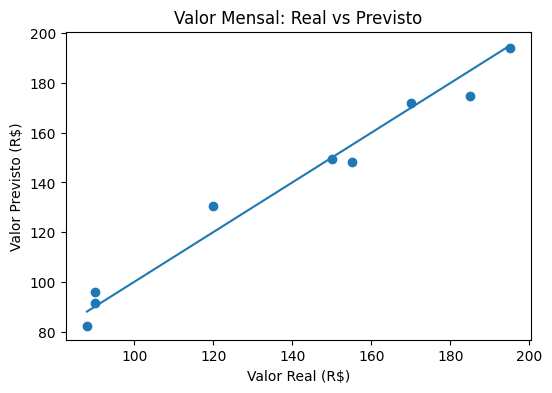

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.xlabel("Valor Real (R$)")
plt.ylabel("Valor Previsto (R$)")
plt.title("Valor Mensal: Real vs Previsto")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.show()


In [15]:
impacto = pd.DataFrame({
    'Variável': X.columns,
    'Impacto no Valor Mensal': model.coef_
}).sort_values(by='Impacto no Valor Mensal')


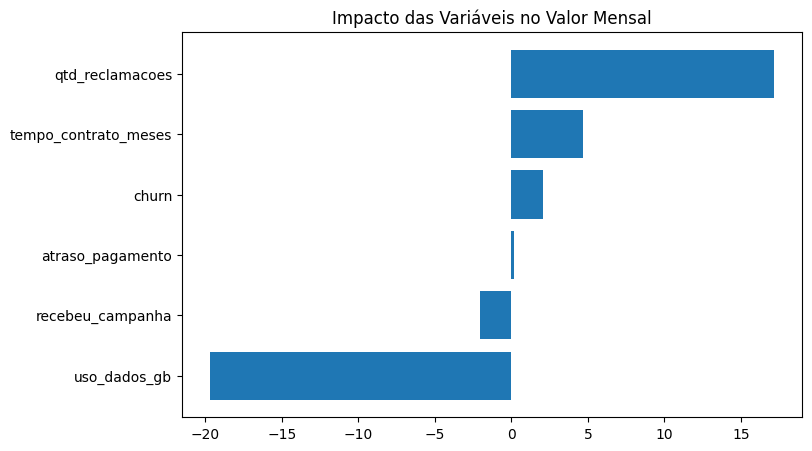

In [16]:
plt.figure(figsize=(8,5))
plt.barh(impacto['Variável'], impacto['Impacto no Valor Mensal'])
plt.title("Impacto das Variáveis no Valor Mensal")
plt.show()


## Gerando valor

In [17]:
df['valor_mensal_previsto'] = model.predict(
    scaler.transform(X)
)


In [20]:
df[['id_cliente', 'valor_mensal', 'valor_mensal_previsto']] \
    .sort_values(by='valor_mensal_previsto', ascending=False) \
    .head(10)


,id_cliente,valor_mensal,valor_mensal_previsto
3,1004,200,195.356796
15,1016,195,193.925031
0,1001,180,176.258574
10,1011,190,175.135381
23,1024,185,174.826809
7,1008,175,173.086473
17,1018,170,171.963279
5,1006,160,170.531514
26,1027,160,170.531514
21,1022,165,169.099748


## Conclusão
- Usamos regressão para prever valor financeiro
- Entendemos os principais drivers de receita
- Criamos uma base para ações de upsell e planejamento
